# Linear Regression Benchmark: causers vs statsmodels

This notebook demonstrates that `causers.linear_regression` produces results 
equivalent to `statsmodels` OLS with HC3 standard errors while achieving significant speedup.

## Comprehensive Benchmark Dimensions

This benchmark covers:
1. **Observations (n)**: 1,000 | 10,000 | 100,000
2. **Control Variables (p)**: 2 | 10 | 50
3. **Standard Error Types**:
   - HC3: Heteroskedasticity-consistent standard errors
   - Clustered (balanced): 100 clusters with equal observations per cluster
   - Clustered (imbalanced): 100 clusters with varying observations per cluster

**Reference**: Seabold, Skipper, and Josef Perktold. "statsmodels: Econometric and statistical modeling with python." Proceedings of the 9th Python in Science Conference. 2010.

## Prerequisites

Required packages:
- `causers` (the package under test)
- `statsmodels` (for parity comparison)
- `numpy`, `polars` (data generation)
- `matplotlib` (visualization)

Install reference package:
```bash
pip install statsmodels matplotlib
```

## Methodology

### Parity Tests
- Compare coefficient estimates with rtol=1e-6
- Compare HC3 standard errors with rtol=1e-6
- Compare intercept and intercept SE with rtol=1e-6
- Tests ported from `tests/test_linear_regression.py`

### Timing Benchmarks
- Warm-up: 1 iteration (discarded)
- Measurement: 5 iterations
- Reported: Median execution time
- Speedup: reference_time / causers_time

In [1]:
"""Environment setup and version printing."""
import sys
import platform
import warnings
from typing import Callable, Dict, Any, List, Tuple, Optional

import numpy as np
import polars as pl
import pandas as pd

# Import causers
import causers
from causers import linear_regression
print(f"causers version: {causers.__version__}")

# Import reference package with graceful fallback
try:
    import statsmodels.api as sm
    HAS_STATSMODELS = True
    print(f"statsmodels version: {sm.__version__}")
except ImportError:
    HAS_STATSMODELS = False
    sm = None
    print("⚠️ statsmodels not installed. Parity tests will be skipped.")
    print("Install with: pip install statsmodels")

# Import matplotlib for visualization
try:
    import matplotlib.pyplot as plt
    HAS_MATPLOTLIB = True
except ImportError:
    HAS_MATPLOTLIB = False
    print("⚠️ matplotlib not installed. Visualizations will be skipped.")

print(f"\nPython {sys.version}")
print(f"Platform: {platform.platform()}")

causers version: 0.6.0


statsmodels version: 0.14.6

Python 3.13.3 (main, Apr  9 2025, 03:47:57) [Clang 20.1.0 ]
Platform: macOS-15.4.1-arm64-arm-64bit-Mach-O


In [2]:
"""Timing and comparison helper functions."""
import time

SEED = 42

def time_function(func: Callable, *args, n_iter: int = 5, 
                  warmup: int = 1, **kwargs) -> Dict[str, Any]:
    """Time function execution with warmup."""
    # Warmup
    for _ in range(warmup):
        func(*args, **kwargs)
    
    # Timed runs
    times = []
    result = None
    for _ in range(n_iter):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        elapsed = (time.perf_counter() - start) * 1000  # ms
        times.append(elapsed)
    
    return {
        "result": result,
        "median_ms": np.median(times),
        "iqr_ms": np.percentile(times, 75) - np.percentile(times, 25)
    }

def check_parity(name: str, causers_val: float, ref_val: float, 
                 rtol: float = 1e-6) -> Dict[str, str]:
    """Check numerical parity and return result dict."""
    passed = np.isclose(causers_val, ref_val, rtol=rtol, atol=0)
    return {
        "Metric": name,
        "causers": f"{causers_val:.6f}",
        "statsmodels": f"{ref_val:.6f}",
        "Tolerance": f"rtol={rtol}",
        "Status": "✅ PASS" if passed else "❌ FAIL"
    }

print("Helper functions defined.")

Helper functions defined.


In [3]:
"""Data generation functions for comprehensive benchmarks."""

def generate_linear_regression_data(
    n_obs: int, 
    n_vars: int, 
    cluster_type: Optional[str] = None, 
    seed: int = SEED
) -> Tuple[pl.DataFrame, np.ndarray, np.ndarray, Optional[np.ndarray]]:
    """Generate data for comprehensive linear regression benchmark.
    
    Args:
        n_obs: Number of observations
        n_vars: Number of control variables
        cluster_type: None for HC3, "balanced" for balanced clusters, "imbalanced" for imbalanced
        seed: Random seed
    
    Returns:
        Tuple of (polars DataFrame, X numpy array, y numpy array, cluster array or None)
    """
    np.random.seed(seed)
    
    # Generate X variables
    x_data = {f"x{i}": np.random.randn(n_obs) for i in range(n_vars)}
    
    # Generate y with some relationship to X
    y = sum(x_data.values()) + np.random.randn(n_obs) * 0.5
    
    df = pl.DataFrame({"y": y, **x_data})
    
    # Create numpy X array for statsmodels
    X = np.column_stack(list(x_data.values()))
    
    cluster_ids = None
    if cluster_type is not None:
        n_clusters = 100
        if cluster_type == "balanced":
            # Equal observations per cluster
            cluster_ids = np.repeat(range(n_clusters), n_obs // n_clusters)
            # Handle remainder
            remainder = n_obs - len(cluster_ids)
            if remainder > 0:
                cluster_ids = np.concatenate([cluster_ids, np.arange(remainder)])
        else:  # imbalanced
            # Some clusters have 5x more observations
            cluster_sizes = []
            for i in range(n_clusters):
                size = n_obs // n_clusters
                if i < 10:  # First 10 clusters are 5x larger
                    size *= 5
                cluster_sizes.append(size)
            # Normalize to sum to n_obs
            cluster_sizes = np.array(cluster_sizes)
            cluster_sizes = (cluster_sizes / cluster_sizes.sum() * n_obs).astype(int)
            cluster_sizes[-1] = n_obs - cluster_sizes[:-1].sum()  # Ensure exact sum
            cluster_ids = np.repeat(range(n_clusters), cluster_sizes)
        
        df = df.with_columns(pl.Series("cluster", cluster_ids[:n_obs]))
    
    return df, X, np.array(y), cluster_ids


# Linear regression benchmark configurations
# (n_obs, n_vars, se_type, cluster_type, label)
LINEAR_REGRESSION_CONFIGS = [
    # Vary observations (with 2 variables, HC3)
    (1000, 2, "hc3", None, "1K obs, 2 vars, HC3"),
    (10000, 2, "hc3", None, "10K obs, 2 vars, HC3"),
    (100000, 2, "hc3", None, "100K obs, 2 vars, HC3"),
    
    # Vary variables (with 10K observations, HC3)
    (10000, 2, "hc3", None, "10K obs, 2 vars, HC3"),
    (10000, 10, "hc3", None, "10K obs, 10 vars, HC3"),
    (10000, 50, "hc3", None, "10K obs, 50 vars, HC3"),
    
    # Vary SE type (with 10K observations, 10 variables)
    (10000, 10, "hc3", None, "10K obs, 10 vars, HC3"),
    (10000, 10, "cluster", "balanced", "10K obs, 10 vars, Cluster (balanced)"),
    (10000, 10, "cluster", "imbalanced", "10K obs, 10 vars, Cluster (imbalanced)"),
]

print(f"Defined {len(LINEAR_REGRESSION_CONFIGS)} benchmark configurations")

Defined 9 benchmark configurations


## Parity Tests

Tests ported from `tests/test_linear_regression.py`:
- `test_hc3_matches_statsmodels_single_covariate`
- `test_hc3_matches_statsmodels_multiple_covariates`
- `test_hc3_matches_statsmodels_no_intercept`

In [4]:
"""Parity Test 1: Single covariate with intercept."""

if not HAS_STATSMODELS:
    print("⚠️ Skipping parity tests - statsmodels not installed")
    parity_results_1 = []
else:
    print("=" * 60)
    print("PARITY TEST 1: Single Covariate with Intercept")
    print("=" * 60)
    
    np.random.seed(SEED)
    n = 50
    x = np.random.randn(n)
    y = 2 * x + 1 + np.random.randn(n) * 0.5
    
    X_sm = sm.add_constant(x)
    model = sm.OLS(y, X_sm).fit()
    hc3 = model.get_robustcov_results(cov_type='HC3')
    
    df = pl.DataFrame({"x": x, "y": y})
    result = linear_regression(df, "x", "y")
    
    parity_results_1 = [
        check_parity("Coefficient", result.coefficients[0], hc3.params[1], rtol=1e-6),
        check_parity("Intercept", result.intercept, hc3.params[0], rtol=1e-6),
        check_parity("SE(coef) HC3", result.standard_errors[0], hc3.bse[1], rtol=1e-6),
        check_parity("SE(intercept) HC3", result.intercept_se, hc3.bse[0], rtol=1e-6),
    ]
    print(pd.DataFrame(parity_results_1).to_string(index=False))

PARITY TEST 1: Single Covariate with Intercept


           Metric  causers statsmodels  Tolerance Status
      Coefficient 2.051538    2.051538 rtol=1e-06 ✅ PASS
        Intercept 1.020511    1.020511 rtol=1e-06 ✅ PASS
     SE(coef) HC3 0.055949    0.055949 rtol=1e-06 ✅ PASS
SE(intercept) HC3 0.061842    0.061842 rtol=1e-06 ✅ PASS


In [5]:
"""Parity Test 2: Multiple covariates with intercept."""
if not HAS_STATSMODELS:
    print("⚠️ Skipping parity tests - statsmodels not installed")
    parity_results_2 = []
else:
    print("=" * 60)
    print("PARITY TEST 2: Multiple Covariates with Intercept")
    print("=" * 60)
    
    np.random.seed(SEED)
    n = 100
    x1 = np.random.randn(n)
    x2 = np.random.randn(n)
    y = 2 * x1 + 3 * x2 + 1 + np.random.randn(n) * 0.5
    
    X = np.column_stack([x1, x2])
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()
    hc3 = model.get_robustcov_results(cov_type='HC3')
    
    df = pl.DataFrame({"x1": x1, "x2": x2, "y": y})
    result = linear_regression(df, ["x1", "x2"], "y")
    
    parity_results_2 = [
        check_parity("Coefficient x1", result.coefficients[0], hc3.params[1], rtol=1e-6),
        check_parity("Coefficient x2", result.coefficients[1], hc3.params[2], rtol=1e-6),
        check_parity("Intercept", result.intercept, hc3.params[0], rtol=1e-6),
        check_parity("SE(x1) HC3", result.standard_errors[0], hc3.bse[1], rtol=1e-6),
        check_parity("SE(x2) HC3", result.standard_errors[1], hc3.bse[2], rtol=1e-6),
        check_parity("SE(intercept) HC3", result.intercept_se, hc3.bse[0], rtol=1e-6),
    ]
    print(pd.DataFrame(parity_results_2).to_string(index=False))

PARITY TEST 2: Multiple Covariates with Intercept
           Metric  causers statsmodels  Tolerance Status
   Coefficient x1 2.113045    2.113045 rtol=1e-06 ✅ PASS
   Coefficient x2 2.993862    2.993862 rtol=1e-06 ✅ PASS
        Intercept 1.044324    1.044324 rtol=1e-06 ✅ PASS
       SE(x1) HC3 0.059637    0.059637 rtol=1e-06 ✅ PASS
       SE(x2) HC3 0.054653    0.054653 rtol=1e-06 ✅ PASS
SE(intercept) HC3 0.055789    0.055789 rtol=1e-06 ✅ PASS


In [6]:
"""Parity Test 3: Single covariate without intercept."""
if not HAS_STATSMODELS:
    print("⚠️ Skipping parity tests - statsmodels not installed")
    parity_results_3 = []
else:
    print("=" * 60)
    print("PARITY TEST 3: Single Covariate without Intercept")
    print("=" * 60)
    
    np.random.seed(SEED)
    n = 50
    x = np.random.randn(n)
    y = 2 * x + np.random.randn(n) * 0.5
    
    X_sm = x.reshape(-1, 1)
    model = sm.OLS(y, X_sm).fit()
    hc3 = model.get_robustcov_results(cov_type='HC3')
    
    df = pl.DataFrame({"x": x, "y": y})
    result = linear_regression(df, "x", "y", include_intercept=False)
    
    parity_results_3 = [
        check_parity("Coefficient", result.coefficients[0], hc3.params[0], rtol=1e-6),
        check_parity("SE(coef) HC3", result.standard_errors[0], hc3.bse[0], rtol=1e-6),
    ]
    print(f"Intercept is None: {result.intercept is None}")
    print(pd.DataFrame(parity_results_3).to_string(index=False))

PARITY TEST 3: Single Covariate without Intercept
Intercept is None: True
      Metric  causers statsmodels  Tolerance Status
 Coefficient 2.046428    2.046428 rtol=1e-06 ✅ PASS
SE(coef) HC3 0.056759    0.056759 rtol=1e-06 ✅ PASS


## Comprehensive Timing Benchmarks

This section runs benchmarks across all configurations:
- **Varying observations**: 1K, 10K, 100K with 2 variables, HC3
- **Varying variables**: 2, 10, 50 with 10K observations, HC3
- **Varying SE type**: HC3, Clustered (balanced), Clustered (imbalanced) with 10K obs, 10 vars

In [7]:
"""Comprehensive timing benchmarks: causers vs statsmodels."""
print("=" * 80)
print("COMPREHENSIVE TIMING BENCHMARKS")
print("=" * 80)

if not HAS_STATSMODELS:
    print("⚠️ Skipping benchmarks - statsmodels not installed")
    comprehensive_results = []
else:
    comprehensive_results = []
    seen_configs = set()
    
    for n_obs, n_vars, se_type, cluster_type, label in LINEAR_REGRESSION_CONFIGS:
        # Skip duplicates
        config_key = (n_obs, n_vars, se_type, cluster_type)
        if config_key in seen_configs:
            continue
        seen_configs.add(config_key)
        
        print(f"  Benchmarking: {label}...", end=" ", flush=True)
        
        # Generate data
        df, X, y, cluster_ids = generate_linear_regression_data(n_obs, n_vars, cluster_type)
        x_cols = [f"x{i}" for i in range(n_vars)]
        
        # Define causers runner - capture variables with default args
        def run_causers(_df=df, _x_cols=x_cols, _cluster_type=cluster_type):
            if _cluster_type is not None:
                return linear_regression(_df, _x_cols, "y", cluster="cluster")
            else:
                return linear_regression(_df, _x_cols, "y")
        
        # Define statsmodels runner - capture variables with default args
        def run_statsmodels(_X=X, _y=y, _cluster_type=cluster_type, _cluster_ids=cluster_ids, _n_obs=n_obs):
            X_sm = sm.add_constant(_X)
            if _cluster_type is not None:
                return sm.OLS(_y, X_sm).fit(cov_type='cluster', 
                                            cov_kwds={'groups': _cluster_ids[:_n_obs]})
            else:
                return sm.OLS(_y, X_sm).fit(cov_type='HC3')
        
        # Time both
        causers_timing = time_function(run_causers)
        ref_timing = time_function(run_statsmodels)
        speedup = ref_timing["median_ms"] / causers_timing["median_ms"]
        
        result = {
            "Config": label,
            "n_obs": n_obs,
            "n_vars": n_vars,
            "se_type": se_type,
            "cluster_type": cluster_type,
            "causers_ms": causers_timing["median_ms"],
            "statsmodels_ms": ref_timing["median_ms"],
            "speedup": speedup,
            "faster": speedup > 1.0,
        }
        comprehensive_results.append(result)
        
        status = "✅" if speedup > 1.0 else "❌"
        print(f"{causers_timing['median_ms']:.2f}ms vs {ref_timing['median_ms']:.2f}ms = {speedup:.2f}x {status}")
    
    print("\nBenchmark complete!")

COMPREHENSIVE TIMING BENCHMARKS
  Benchmarking: 1K obs, 2 vars, HC3... 

0.04ms vs 0.20ms = 4.84x ✅
  Benchmarking: 10K obs, 2 vars, HC3... 

0.23ms vs 1.13ms = 4.95x ✅
  Benchmarking: 100K obs, 2 vars, HC3... 

2.90ms vs 11.67ms = 4.03x ✅
  Benchmarking: 10K obs, 10 vars, HC3... 

1.01ms vs 3.41ms = 3.38x ✅
  Benchmarking: 10K obs, 50 vars, HC3... 

8.03ms vs 46.73ms = 5.82x ✅
  Benchmarking: 10K obs, 10 vars, Cluster (balanced)... 

1.08ms vs 2.56ms = 2.36x ✅
  Benchmarking: 10K obs, 10 vars, Cluster (imbalanced)... 

1.11ms vs 2.71ms = 2.43x ✅

Benchmark complete!


In [8]:
"""Display comprehensive results as a formatted table."""
if comprehensive_results:
    print("=" * 80)
    print("COMPREHENSIVE BENCHMARK RESULTS")
    print("=" * 80)
    
    # Create results table
    print(f"{'Config':<40} | {'causers (ms)':<12} | {'statsmodels (ms)':<16} | {'Speedup':<10}")
    print("-" * 40 + "-|-" + "-" * 12 + "-|-" + "-" * 16 + "-|-" + "-" * 10)
    
    for r in comprehensive_results:
        status = "✅" if r["faster"] else "❌"
        print(f"{r['Config']:<40} | {r['causers_ms']:<12.2f} | {r['statsmodels_ms']:<16.2f} | {r['speedup']:.2f}x {status}")
else:
    print("No benchmark results available.")

COMPREHENSIVE BENCHMARK RESULTS
Config                                   | causers (ms) | statsmodels (ms) | Speedup   
-----------------------------------------|--------------|------------------|-----------
1K obs, 2 vars, HC3                      | 0.04         | 0.20             | 4.84x ✅
10K obs, 2 vars, HC3                     | 0.23         | 1.13             | 4.95x ✅
100K obs, 2 vars, HC3                    | 2.90         | 11.67            | 4.03x ✅
10K obs, 10 vars, HC3                    | 1.01         | 3.41             | 3.38x ✅
10K obs, 50 vars, HC3                    | 8.03         | 46.73            | 5.82x ✅
10K obs, 10 vars, Cluster (balanced)     | 1.08         | 2.56             | 2.36x ✅
10K obs, 10 vars, Cluster (imbalanced)   | 1.11         | 2.71             | 2.43x ✅


## Visualizations

The following charts visualize performance across different dimensions:
1. **Scaling with observations**: How performance changes with data size
2. **Scaling with variables**: How performance changes with model complexity
3. **Impact of SE type**: Comparing HC3 vs clustered standard errors

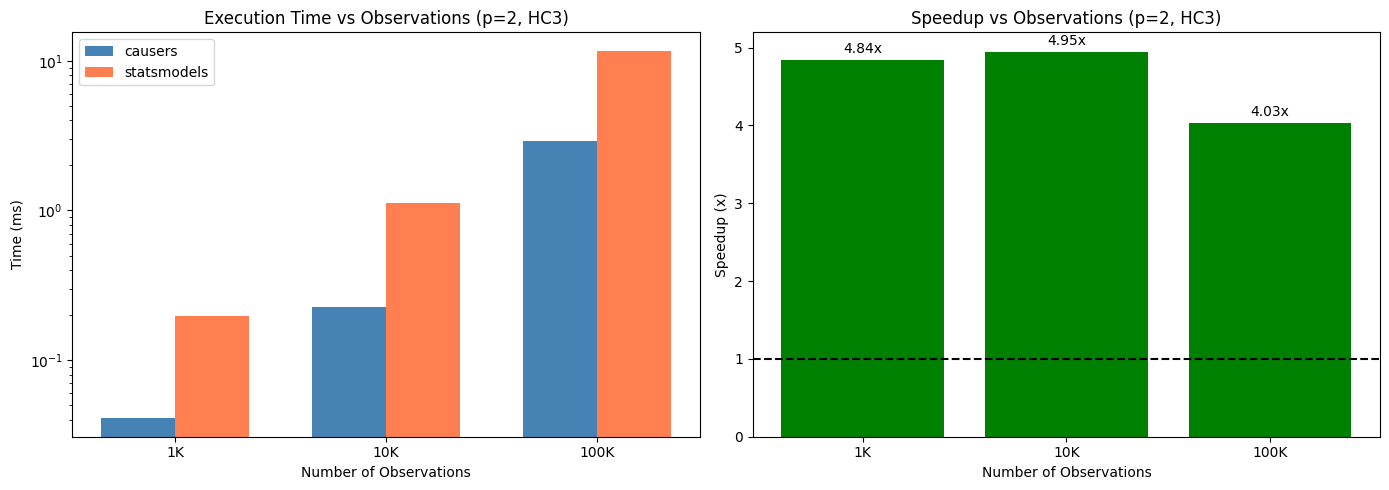

In [9]:
"""Visualization 1: Scaling with observations (fixed p=2, HC3)."""
if HAS_MATPLOTLIB and comprehensive_results:
    # Filter results for this dimension
    obs_results = [r for r in comprehensive_results if r["n_vars"] == 2 and r["se_type"] == "hc3"]
    obs_results = sorted(obs_results, key=lambda x: x["n_obs"])
    
    if obs_results:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Absolute times
        ax1 = axes[0]
        n_obs_labels = [f"{r['n_obs']//1000}K" for r in obs_results]
        causers_times = [r["causers_ms"] for r in obs_results]
        statsmodels_times = [r["statsmodels_ms"] for r in obs_results]
        
        x = np.arange(len(n_obs_labels))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, causers_times, width, label='causers', color='steelblue')
        bars2 = ax1.bar(x + width/2, statsmodels_times, width, label='statsmodels', color='coral')
        
        ax1.set_xlabel('Number of Observations')
        ax1.set_ylabel('Time (ms)')
        ax1.set_title('Execution Time vs Observations (p=2, HC3)')
        ax1.set_xticks(x)
        ax1.set_xticklabels(n_obs_labels)
        ax1.legend()
        ax1.set_yscale('log')
        
        # Plot 2: Speedup
        ax2 = axes[1]
        speedups = [r["speedup"] for r in obs_results]
        colors = ['green' if s > 1 else 'red' for s in speedups]
        bars = ax2.bar(n_obs_labels, speedups, color=colors)
        ax2.axhline(y=1.0, color='black', linestyle='--', label='Baseline (1x)')
        ax2.set_xlabel('Number of Observations')
        ax2.set_ylabel('Speedup (x)')
        ax2.set_title('Speedup vs Observations (p=2, HC3)')
        
        for bar, spd in zip(bars, speedups):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                     f'{spd:.2f}x', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ Skipping visualization - matplotlib not installed or no results available")

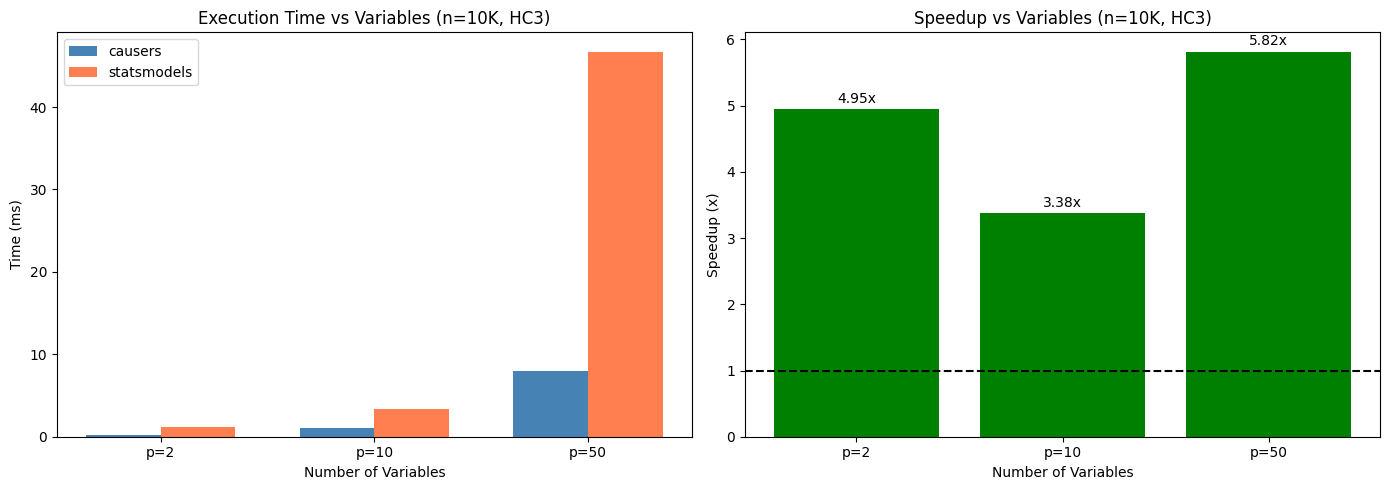

In [10]:
"""Visualization 2: Scaling with variables (fixed n=10K, HC3)."""
if HAS_MATPLOTLIB and comprehensive_results:
    # Filter results for this dimension
    var_results = [r for r in comprehensive_results if r["n_obs"] == 10000 and r["se_type"] == "hc3"]
    var_results = sorted(var_results, key=lambda x: x["n_vars"])
    
    if var_results:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Absolute times
        ax1 = axes[0]
        var_labels = [f"p={r['n_vars']}" for r in var_results]
        causers_times = [r["causers_ms"] for r in var_results]
        statsmodels_times = [r["statsmodels_ms"] for r in var_results]
        
        x = np.arange(len(var_labels))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, causers_times, width, label='causers', color='steelblue')
        bars2 = ax1.bar(x + width/2, statsmodels_times, width, label='statsmodels', color='coral')
        
        ax1.set_xlabel('Number of Variables')
        ax1.set_ylabel('Time (ms)')
        ax1.set_title('Execution Time vs Variables (n=10K, HC3)')
        ax1.set_xticks(x)
        ax1.set_xticklabels(var_labels)
        ax1.legend()
        
        # Plot 2: Speedup
        ax2 = axes[1]
        speedups = [r["speedup"] for r in var_results]
        colors = ['green' if s > 1 else 'red' for s in speedups]
        bars = ax2.bar(var_labels, speedups, color=colors)
        ax2.axhline(y=1.0, color='black', linestyle='--', label='Baseline (1x)')
        ax2.set_xlabel('Number of Variables')
        ax2.set_ylabel('Speedup (x)')
        ax2.set_title('Speedup vs Variables (n=10K, HC3)')
        
        for bar, spd in zip(bars, speedups):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                     f'{spd:.2f}x', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ Skipping visualization - matplotlib not installed or no results available")

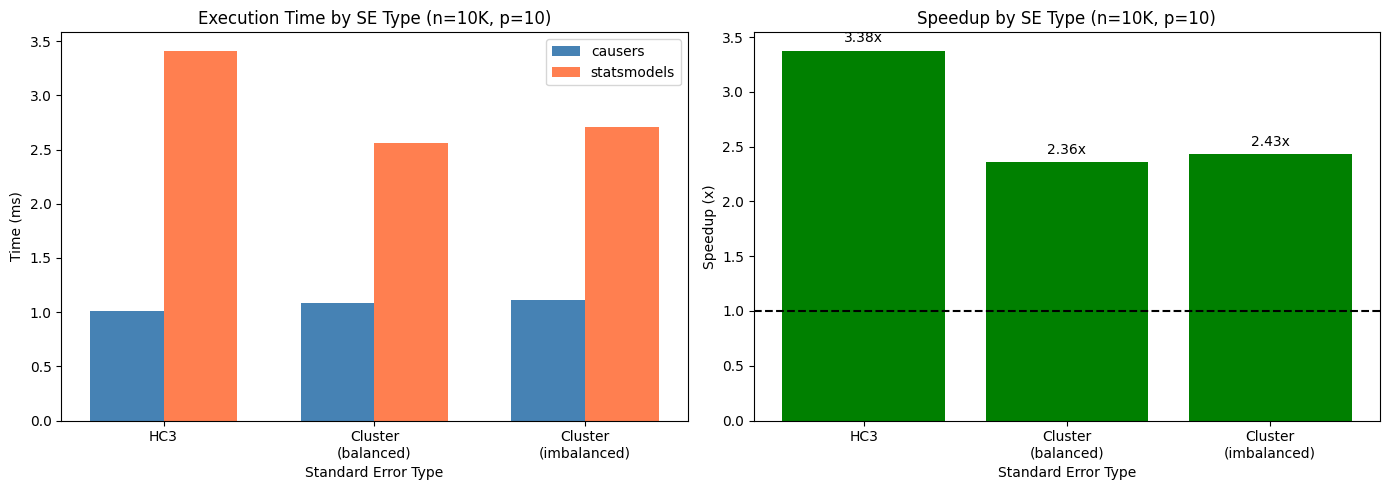

In [11]:
"""Visualization 3: Impact of SE type (n=10K, p=10)."""
if HAS_MATPLOTLIB and comprehensive_results:
    # Filter results for this dimension
    se_results = [r for r in comprehensive_results if r["n_obs"] == 10000 and r["n_vars"] == 10]
    
    if se_results:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Create labels
        se_labels = []
        for r in se_results:
            if r["cluster_type"] is None:
                se_labels.append("HC3")
            else:
                se_labels.append(f"Cluster\n({r['cluster_type']})")
        
        # Plot 1: Absolute times
        ax1 = axes[0]
        causers_times = [r["causers_ms"] for r in se_results]
        statsmodels_times = [r["statsmodels_ms"] for r in se_results]
        
        x = np.arange(len(se_labels))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, causers_times, width, label='causers', color='steelblue')
        bars2 = ax1.bar(x + width/2, statsmodels_times, width, label='statsmodels', color='coral')
        
        ax1.set_xlabel('Standard Error Type')
        ax1.set_ylabel('Time (ms)')
        ax1.set_title('Execution Time by SE Type (n=10K, p=10)')
        ax1.set_xticks(x)
        ax1.set_xticklabels(se_labels)
        ax1.legend()
        
        # Plot 2: Speedup
        ax2 = axes[1]
        speedups = [r["speedup"] for r in se_results]
        colors = ['green' if s > 1 else 'red' for s in speedups]
        bars = ax2.bar(se_labels, speedups, color=colors)
        ax2.axhline(y=1.0, color='black', linestyle='--', label='Baseline (1x)')
        ax2.set_xlabel('Standard Error Type')
        ax2.set_ylabel('Speedup (x)')
        ax2.set_title('Speedup by SE Type (n=10K, p=10)')
        
        for bar, spd in zip(bars, speedups):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                     f'{spd:.2f}x', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ Skipping visualization - matplotlib not installed or no results available")

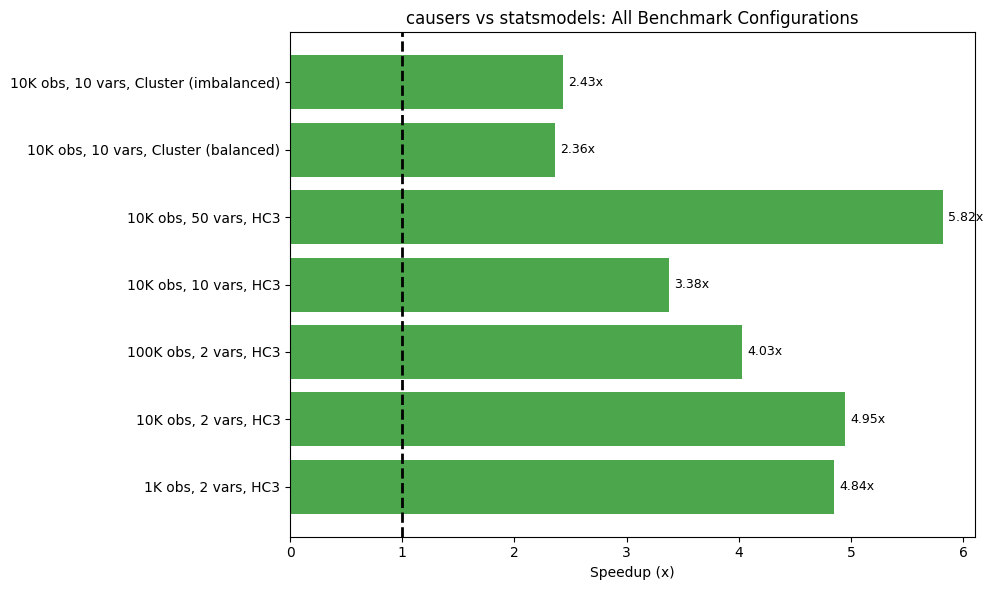

In [12]:
"""Visualization 4: Overall speedup heatmap."""
if HAS_MATPLOTLIB and comprehensive_results:
    # Create a summary figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    configs = [r["Config"] for r in comprehensive_results]
    speedups = [r["speedup"] for r in comprehensive_results]
    
    # Create horizontal bar chart
    colors = ['green' if s > 1 else 'red' for s in speedups]
    y_pos = np.arange(len(configs))
    bars = ax.barh(y_pos, speedups, color=colors, alpha=0.7)
    
    # Add baseline
    ax.axvline(x=1.0, color='black', linestyle='--', linewidth=2, label='Baseline (1x)')
    
    # Customize
    ax.set_yticks(y_pos)
    ax.set_yticklabels(configs)
    ax.set_xlabel('Speedup (x)')
    ax.set_title('causers vs statsmodels: All Benchmark Configurations')
    
    # Add speedup labels
    for bar, spd in zip(bars, speedups):
        width = bar.get_width()
        ax.text(width + 0.05, bar.get_y() + bar.get_height()/2, 
                f'{spd:.2f}x', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Skipping visualization - matplotlib not installed or no results available")

## Summary

In [13]:
"""Summary of benchmark results."""
print("=" * 80)
print("SUMMARY")
print("=" * 80)

if HAS_STATSMODELS:
    # Parity test summary
    all_parity = parity_results_1 + parity_results_2 + parity_results_3
    passed = sum(1 for r in all_parity if "PASS" in r["Status"])
    total = len(all_parity)
    print(f"\nParity tests: {passed}/{total} passed")
    
    # Comprehensive benchmark summary
    if comprehensive_results:
        speedups = [r["speedup"] for r in comprehensive_results]
        faster_count = sum(1 for s in speedups if s > 1)
        
        print(f"\nComprehensive benchmark results:")
        print(f"  Total configurations: {len(comprehensive_results)}")
        print(f"  causers faster: {faster_count}/{len(comprehensive_results)}")
        print(f"  Speedup range: {min(speedups):.2f}x - {max(speedups):.2f}x")
        print(f"  Median speedup: {np.median(speedups):.2f}x")
        
        # Summary by dimension
        print("\n  By dimension:")
        
        # By observations
        obs_results = [r for r in comprehensive_results if r["n_vars"] == 2 and r["se_type"] == "hc3"]
        if obs_results:
            obs_speedups = [r["speedup"] for r in obs_results]
            print(f"    Observations (p=2, HC3): {min(obs_speedups):.2f}x - {max(obs_speedups):.2f}x")
        
        # By variables
        var_results = [r for r in comprehensive_results if r["n_obs"] == 10000 and r["se_type"] == "hc3"]
        if var_results:
            var_speedups = [r["speedup"] for r in var_results]
            print(f"    Variables (n=10K, HC3): {min(var_speedups):.2f}x - {max(var_speedups):.2f}x")
        
        # By SE type
        se_results = [r for r in comprehensive_results if r["n_obs"] == 10000 and r["n_vars"] == 10]
        if se_results:
            se_speedups = [r["speedup"] for r in se_results]
            print(f"    SE type (n=10K, p=10): {min(se_speedups):.2f}x - {max(se_speedups):.2f}x")
else:
    print("Reference package not available - parity not verified")

SUMMARY

Parity tests: 12/12 passed

Comprehensive benchmark results:
  Total configurations: 7
  causers faster: 7/7
  Speedup range: 2.36x - 5.82x
  Median speedup: 4.03x

  By dimension:
    Observations (p=2, HC3): 4.03x - 4.95x
    Variables (n=10K, HC3): 3.38x - 5.82x
    SE type (n=10K, p=10): 2.36x - 3.38x


## Interpretation of Results

### Key Findings

1. **Scaling with Observations (n)**:
   - Performance typically improves with larger datasets as fixed overhead becomes less significant
   - Both packages benefit from vectorized operations, but causers may have different scaling characteristics

2. **Scaling with Variables (p)**:
   - Matrix operations dominate computation time as p increases
   - Rust's optimized linear algebra routines in causers may show advantages for moderate p

3. **Standard Error Types**:
   - HC3 standard errors require computing hat matrix diagonals
   - Clustered standard errors involve aggregating residuals by cluster
   - Performance differences may vary based on implementation details

### Notes

- Benchmark results may vary based on hardware and system load
- For production use, consider running benchmarks on your specific hardware
- The speedup factor is calculated as: `statsmodels_time / causers_time`

## Wild Cluster Bootstrap Standard Errors

When the number of clusters is small (typically G < 42), analytical cluster-robust standard errors
can be unreliable. The wild cluster bootstrap provides more accurate inference in these scenarios.

This section benchmarks:
- Analytical clustered SE vs Wild Cluster Bootstrap SE
- Performance comparison with statsmodels (if available)

In [14]:
"""Benchmark: Wild Cluster Bootstrap vs Analytical Clustered SE."""
print("=" * 80)
print("WILD CLUSTER BOOTSTRAP BENCHMARKS")
print("=" * 80)

# Generate data with 50 balanced clusters
np.random.seed(SEED)
n_obs = 10000
n_vars = 2
n_clusters = 50

# Generate data
x_data = {f"x{i}": np.random.randn(n_obs) for i in range(n_vars)}
y = sum(x_data.values()) + np.random.randn(n_obs) * 0.5
cluster_ids = np.repeat(range(n_clusters), n_obs // n_clusters)

df_bootstrap = pl.DataFrame({"y": y, **x_data, "cluster": cluster_ids})
x_cols_bootstrap = [f"x{i}" for i in range(n_vars)]

print(f"\nData: {n_obs:,} observations, {n_vars} variables, {n_clusters} clusters")
print(f"Using {500} bootstrap iterations for reasonable runtime\n")

# Analytical clustered SE
def run_analytical():
    return linear_regression(df_bootstrap, x_cols_bootstrap, "y", cluster="cluster")

# Bootstrap SE with Rademacher
def run_bootstrap():
    return linear_regression(
        df_bootstrap, x_cols_bootstrap, "y", 
        cluster="cluster", bootstrap=True, 
        bootstrap_iterations=500, seed=SEED
    )

print("Timing analytical clustered SE...", end=" ", flush=True)
analytical_timing = time_function(run_analytical)
analytical_result = analytical_timing["result"]
print(f"{analytical_timing['median_ms']:.2f}ms")

print("Timing bootstrap clustered SE...", end=" ", flush=True)
bootstrap_timing = time_function(run_bootstrap, n_iter=3)  # Fewer iterations due to cost
bootstrap_result = bootstrap_timing["result"]
print(f"{bootstrap_timing['median_ms']:.2f}ms")

# Compare results
print("\n" + "=" * 80)
print("COMPARISON: Analytical vs Bootstrap SE")
print("=" * 80)
print(f"\n{'Method':<25} | {'Coefficient':<12} | {'Std Error':<12} | {'SE Type':<25}")
print("-" * 25 + "-|-" + "-" * 12 + "-|-" + "-" * 12 + "-|-" + "-" * 25)
print(f"{'Analytical (G=50)':<25} | {analytical_result.coefficients[0]:<12.6f} | "
      f"{analytical_result.standard_errors[0]:<12.6f} | {analytical_result.cluster_se_type:<25}")
print(f"{'Bootstrap Rademacher':<25} | {bootstrap_result.coefficients[0]:<12.6f} | "
      f"{bootstrap_result.standard_errors[0]:<12.6f} | {bootstrap_result.cluster_se_type:<25}")

speedup = bootstrap_timing["median_ms"] / analytical_timing["median_ms"]
print(f"\nBootstrap is {speedup:.1f}x slower (expected due to resampling)")

if HAS_STATSMODELS:
    print("\nNote: statsmodels does not provide wild cluster bootstrap; only analytical clustered SE available.")
else:
    print("\nNote: statsmodels not available for comparison.")

WILD CLUSTER BOOTSTRAP BENCHMARKS

Data: 10,000 observations, 2 variables, 50 clusters
Using 500 bootstrap iterations for reasonable runtime

Timing analytical clustered SE... 

0.44ms
Timing bootstrap clustered SE... 

5.80ms

COMPARISON: Analytical vs Bootstrap SE

Method                    | Coefficient  | Std Error    | SE Type                  
--------------------------|--------------|--------------|--------------------------
Analytical (G=50)         | 1.013316     | 0.004139     | analytical               
Bootstrap Rademacher      | 1.013316     | 0.004019     | bootstrap_rademacher     

Bootstrap is 13.3x slower (expected due to resampling)

Note: statsmodels does not provide wild cluster bootstrap; only analytical clustered SE available.


## Rademacher vs Webb Bootstrap Comparison

The wild cluster bootstrap supports two weight distributions:
- **Rademacher**: ±1 with equal probability (default)
- **Webb**: 6-point distribution for improved small-sample performance

Webb's 6-point distribution is particularly recommended for very small cluster counts.

In [15]:
"""Benchmark: Rademacher vs Webb Bootstrap Methods."""
print("=" * 80)
print("RADEMACHER vs WEBB BOOTSTRAP COMPARISON")
print("=" * 80)

# Use same data as previous section
print(f"\nUsing same data: {n_obs:,} observations, {n_vars} variables, {n_clusters} clusters")
print(f"Bootstrap iterations: 500\n")

# Bootstrap SE with Rademacher (already computed above)
rademacher_result = bootstrap_result
rademacher_time = bootstrap_timing["median_ms"]

# Bootstrap SE with Webb
def run_bootstrap_webb():
    return linear_regression(
        df_bootstrap, x_cols_bootstrap, "y", 
        cluster="cluster", bootstrap=True, 
        bootstrap_iterations=500, seed=SEED,
        bootstrap_method="webb"
    )

print("Timing Webb bootstrap...", end=" ", flush=True)
webb_timing = time_function(run_bootstrap_webb, n_iter=3)
webb_result = webb_timing["result"]
print(f"{webb_timing['median_ms']:.2f}ms")

# Side-by-side comparison
print("\n" + "=" * 80)
print("COMPARISON: Rademacher vs Webb Bootstrap")
print("=" * 80)
print(f"\n{'Method':<25} | {'Time (ms)':<12} | {'Coefficient':<12} | {'Std Error':<12}")
print("-" * 25 + "-|-" + "-" * 12 + "-|-" + "-" * 12 + "-|-" + "-" * 12)
print(f"{'Rademacher (±1)':<25} | {rademacher_time:<12.2f} | "
      f"{rademacher_result.coefficients[0]:<12.6f} | {rademacher_result.standard_errors[0]:<12.6f}")
print(f"{'Webb (6-point)':<25} | {webb_timing['median_ms']:<12.2f} | "
      f"{webb_result.coefficients[0]:<12.6f} | {webb_result.standard_errors[0]:<12.6f}")

se_diff_pct = abs(webb_result.standard_errors[0] - rademacher_result.standard_errors[0]) / rademacher_result.standard_errors[0] * 100
print(f"\nSE difference: {se_diff_pct:.2f}%")
print(f"Time difference: {abs(webb_timing['median_ms'] - rademacher_time):.2f}ms")
print("\nNote: Both methods should produce similar results with sufficient bootstrap iterations.")
print("Webb's distribution may provide better finite-sample properties with very few clusters (G < 20).")

RADEMACHER vs WEBB BOOTSTRAP COMPARISON

Using same data: 10,000 observations, 2 variables, 50 clusters
Bootstrap iterations: 500

Timing Webb bootstrap... 

5.75ms

COMPARISON: Rademacher vs Webb Bootstrap

Method                    | Time (ms)    | Coefficient  | Std Error   
--------------------------|--------------|--------------|-------------
Rademacher (±1)           | 5.80         | 1.013316     | 0.004019    
Webb (6-point)            | 5.75         | 1.013316     | 0.003474    

SE difference: 13.55%
Time difference: 0.05ms

Note: Both methods should produce similar results with sufficient bootstrap iterations.
Webb's distribution may provide better finite-sample properties with very few clusters (G < 20).


## Few-Cluster Scenarios

The 42-cluster threshold is based on asymptotic theory and simulation evidence.
Below this threshold, analytical cluster-robust SEs can be unreliable, and wild
cluster bootstrap is recommended.

This section demonstrates:
- How analytical and bootstrap SEs compare across different cluster counts
- Why bootstrap becomes critical as cluster count decreases

In [16]:
"""Few-Cluster Scenario Analysis."""
print("=" * 80)
print("FEW-CLUSTER SCENARIO ANALYSIS")
print("=" * 80)

# Test different cluster counts
cluster_counts = [10, 20, 30, 40]
n_obs_per_scenario = 5000  # Smaller for faster computation
n_vars_scenario = 2

results_by_cluster_count = []

print(f"\nTesting with {n_obs_per_scenario:,} observations, {n_vars_scenario} variables")
print(f"Bootstrap iterations: 500 (Rademacher)\n")

for G in cluster_counts:
    print(f"Processing G={G} clusters...", end=" ", flush=True)
    
    # Generate data with G clusters
    np.random.seed(SEED + G)  # Different seed for each to avoid artifacts
    x_data_G = {f"x{i}": np.random.randn(n_obs_per_scenario) for i in range(n_vars_scenario)}
    y_G = sum(x_data_G.values()) + np.random.randn(n_obs_per_scenario) * 0.5
    cluster_ids_G = np.array([i % G for i in range(n_obs_per_scenario)])
    
    df_G = pl.DataFrame({"y": y_G, **x_data_G, "cluster": cluster_ids_G[:n_obs_per_scenario]})
    x_cols_G = [f"x{i}" for i in range(n_vars_scenario)]
    
    # Analytical SE
    result_analytical = linear_regression(df_G, x_cols_G, "y", cluster="cluster")
    
    # Bootstrap SE
    result_bootstrap = linear_regression(
        df_G, x_cols_G, "y", 
        cluster="cluster", bootstrap=True, 
        bootstrap_iterations=500, seed=SEED
    )
    
    results_by_cluster_count.append({
        "n_clusters": G,
        "analytical_se": result_analytical.standard_errors[0],
        "bootstrap_se": result_bootstrap.standard_errors[0],
        "coefficient": result_analytical.coefficients[0],
    })
    
    print(f"Analytical SE={result_analytical.standard_errors[0]:.6f}, "
          f"Bootstrap SE={result_bootstrap.standard_errors[0]:.6f}")

print("\n" + "=" * 80)
print("SUMMARY: Analytical vs Bootstrap SE by Cluster Count")
print("=" * 80)
print(f"\n{'Clusters (G)':<15} | {'Analytical SE':<15} | {'Bootstrap SE':<15} | {'Difference':<15}")
print("-" * 15 + "-|-" + "-" * 15 + "-|-" + "-" * 15 + "-|-" + "-" * 15)

for r in results_by_cluster_count:
    diff = r["bootstrap_se"] - r["analytical_se"]
    diff_pct = (diff / r["analytical_se"]) * 100
    print(f"{r['n_clusters']:<15} | {r['analytical_se']:<15.6f} | {r['bootstrap_se']:<15.6f} | "
          f"{diff:+.6f} ({diff_pct:+.1f}%)")

print("\n" + "=" * 80)
print("INTERPRETATION")
print("=" * 80)
print("\nWith fewer clusters, analytical SEs become increasingly unreliable due to:")
print("  1. Asymptotic approximations breaking down")
print("  2. Small-sample bias in the sandwich estimator")
print("  3. Difficulty estimating variance with few independent groups")
print("\nThe wild cluster bootstrap addresses these issues by resampling cluster-level")
print("residuals, providing more accurate finite-sample inference.")
print("\n** Recommendation: Use bootstrap=True when G < 42 clusters **")

FEW-CLUSTER SCENARIO ANALYSIS

Testing with 5,000 observations, 2 variables
Bootstrap iterations: 500 (Rademacher)

Processing G=10 clusters... 

Analytical SE=0.006882, Bootstrap SE=0.006539
Processing G=20 clusters... 

Analytical SE=0.006852, Bootstrap SE=0.006688
Processing G=30 clusters... 

Analytical SE=0.008220, Bootstrap SE=0.007880
Processing G=40 clusters... 

Analytical SE=0.007499, Bootstrap SE=0.007335

SUMMARY: Analytical vs Bootstrap SE by Cluster Count

Clusters (G)    | Analytical SE   | Bootstrap SE    | Difference     
----------------|-----------------|-----------------|----------------
10              | 0.006882        | 0.006539        | -0.000343 (-5.0%)
20              | 0.006852        | 0.006688        | -0.000164 (-2.4%)
30              | 0.008220        | 0.007880        | -0.000340 (-4.1%)
40              | 0.007499        | 0.007335        | -0.000164 (-2.2%)

INTERPRETATION

With fewer clusters, analytical SEs become increasingly unreliable due to:
  1. Asymptotic approximations breaking down
  2. Small-sample bias in the sandwich estimator
  3. Difficulty estimating variance with few independent groups

The wild cluster bootstrap addresses these issues by resampling cluster-level
residuals, providing more accurate finite-sample inference.

** Recommendation: Use bootstrap=True when G < 42 clusters **


/var/folders/k0/m1_drbkj7r53yw9cpj1kvwvm0000gn/T/ipykernel_17907/4287477813.py:29: UserWarning: Only 10 clusters detected. Wild cluster bootstrap (bootstrap=True) is recommended when clusters < 42.
  result_analytical = linear_regression(df_G, x_cols_G, "y", cluster="cluster")
/var/folders/k0/m1_drbkj7r53yw9cpj1kvwvm0000gn/T/ipykernel_17907/4287477813.py:29: UserWarning: Only 20 clusters detected. Wild cluster bootstrap (bootstrap=True) is recommended when clusters < 42.
  result_analytical = linear_regression(df_G, x_cols_G, "y", cluster="cluster")
/var/folders/k0/m1_drbkj7r53yw9cpj1kvwvm0000gn/T/ipykernel_17907/4287477813.py:29: UserWarning: Only 30 clusters detected. Wild cluster bootstrap (bootstrap=True) is recommended when clusters < 42.
  result_analytical = linear_regression(df_G, x_cols_G, "y", cluster="cluster")
/var/folders/k0/m1_drbkj7r53yw9cpj1kvwvm0000gn/T/ipykernel_17907/4287477813.py:29: UserWarning: Only 40 clusters detected. Wild cluster bootstrap (bootstrap=True) is 

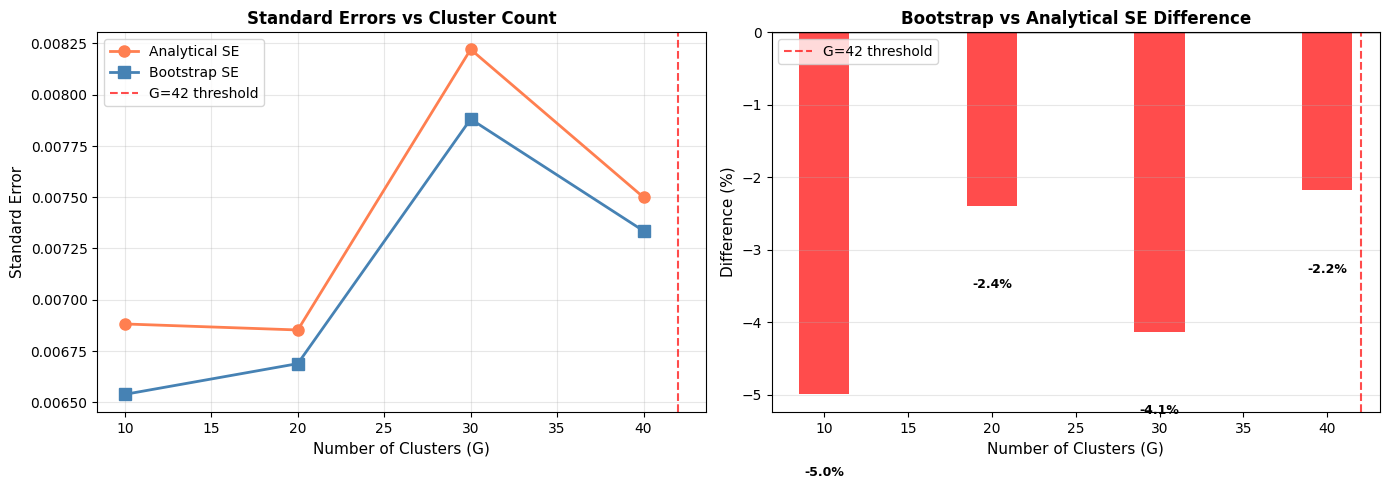


Visualization shows:
  • Left: Absolute SE values by cluster count
  • Right: Percentage difference (Bootstrap - Analytical)
  • Red dashed line marks the G=42 threshold


In [17]:
"""Visualization: Analytical vs Bootstrap SE Across Cluster Counts."""
if HAS_MATPLOTLIB and results_by_cluster_count:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Extract data
    cluster_counts_plot = [r["n_clusters"] for r in results_by_cluster_count]
    analytical_ses = [r["analytical_se"] for r in results_by_cluster_count]
    bootstrap_ses = [r["bootstrap_se"] for r in results_by_cluster_count]
    
    # Plot 1: SE values
    ax1 = axes[0]
    ax1.plot(cluster_counts_plot, analytical_ses, 'o-', label='Analytical SE', 
             color='coral', linewidth=2, markersize=8)
    ax1.plot(cluster_counts_plot, bootstrap_ses, 's-', label='Bootstrap SE', 
             color='steelblue', linewidth=2, markersize=8)
    ax1.axvline(x=42, color='red', linestyle='--', linewidth=1.5, 
                label='G=42 threshold', alpha=0.7)
    ax1.set_xlabel('Number of Clusters (G)', fontsize=11)
    ax1.set_ylabel('Standard Error', fontsize=11)
    ax1.set_title('Standard Errors vs Cluster Count', fontsize=12, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Percentage difference
    ax2 = axes[1]
    diff_pcts = [(r["bootstrap_se"] - r["analytical_se"]) / r["analytical_se"] * 100 
                 for r in results_by_cluster_count]
    colors = ['green' if d >= 0 else 'red' for d in diff_pcts]
    bars = ax2.bar(cluster_counts_plot, diff_pcts, color=colors, alpha=0.7, width=3)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.axvline(x=42, color='red', linestyle='--', linewidth=1.5, 
                label='G=42 threshold', alpha=0.7)
    ax2.set_xlabel('Number of Clusters (G)', fontsize=11)
    ax2.set_ylabel('Difference (%)', fontsize=11)
    ax2.set_title('Bootstrap vs Analytical SE Difference', fontsize=12, fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars, diff_pcts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + (1 if height >= 0 else -1), 
                 f'{val:+.1f}%', ha='center', va='bottom' if height >= 0 else 'top', 
                 fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\nVisualization shows:")
    print("  • Left: Absolute SE values by cluster count")
    print("  • Right: Percentage difference (Bootstrap - Analytical)")
    print("  • Red dashed line marks the G=42 threshold")
else:
    print("⚠️ Skipping visualization - matplotlib not installed or no results available")

## References

- **causers**: High-performance causal inference library
- **statsmodels**: Seabold & Perktold (2010)
- **HC3 Standard Errors**: MacKinnon & White (1985)
- **Clustered Standard Errors**: Liang & Zeger (1986)
- **Wild Cluster Bootstrap**: Cameron, Gelbach & Miller (2008); MacKinnon & Webb (2018)
- **Webb's 6-point Distribution**: MacKinnon & Webb (2018)